In [1]:
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper
from gymnasium.wrappers import ResizeObservation
# import env_wrapper
from pprint import pprint
envs = [env_id for env_id in gymnasium.envs.registry.keys() if "MiniGrid" in env_id]



In [2]:
env_names = ["MiniGrid-Empty-8x8-v0", "MiniGrid-SimpleCrossingS9N3-v0", "MiniGrid-DoorKey-8x8-v0", "MiniGrid-FourRooms-v0"] 

# Single Env

In [13]:
env = gymnasium.make("MiniGrid-FourRooms-v0")
# env = RGBImgPartialObsWrapper(env)  # Adds an "rgb" key to the obs
env = RGBImgObsWrapper(env)  # Adds an "rgb" key to the obs
env = ImgObsWrapper(env)     # Sets obs = obs["rgb"], discards others
env = ResizeObservation(env, shape=(64,64))

In [14]:
obs, info = env.reset()
obs.shape, info
# env.render()

((64, 64, 3), {})

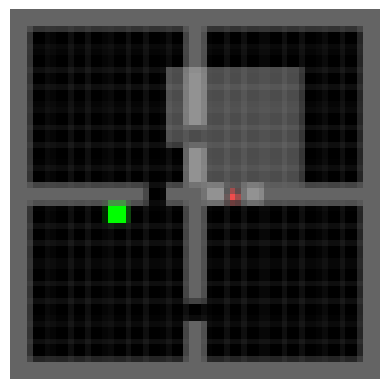

In [15]:
import matplotlib.pyplot as plt

plt.imshow(obs)
plt.axis('off')
plt.show()

In [15]:
obs["image"].shape

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Multi-Envs

In [38]:
# import env_wrapper
def build_single_env(env_name: str, image_size: int):
    """
    Build a single env with wrappers and preprocesses env.
    """
    env = gymnasium.make(
        env_name, render_mode="rgb_array")
    # Convert int to tuple as gymnasium.wrappers.ResizeObservation requires tuple
    if isinstance(image_size, int):
        image_size = (image_size, image_size)
    env = minigrid.wrappers.RGBImgPartialObsWrapper(env)  # Adds an "rgb" key to the obs
    env = minigrid.wrappers.ImgObsWrapper(env)  # Sets obs = obs["rgb"], discards others
    env = gymnasium.wrappers.ResizeObservation(env, shape=image_size)
    # env = env_wrapper.LifeLossInfo(env)

    return env

In [39]:
from functools import partial
def build_vec_env(env_names: list[str], image_size: int):
    """
    Build a vectorized env with n=num_envs parallel envs.
    """
    env_fns = [
        partial(build_single_env, env_name, image_size) for env_name in env_names
    ]
    vec_env = gymnasium.vector.AsyncVectorEnv(env_fns=env_fns)
    return vec_env

In [40]:
env_names = ["MiniGrid-Empty-8x8-v0", "MiniGrid-SimpleCrossingS9N3-v0", "MiniGrid-DoorKey-8x8-v0", "MiniGrid-FourRooms-v0"] 
env = build_single_env(env_names[0], image_size=64)
vec_env = build_vec_env(env_names, image_size=64)

In [41]:
current_obs, current_info = vec_env.reset()
current_obs.shape, current_info

((4, 64, 64, 3), {})

In [7]:
info_keys = set()
for _ in range(100):
    obs, info = vec_env.reset()
    info_keys.update(info.keys())
    for _ in range(50):
        _, _, terminated, truncated, info = vec_env.step(vec_env.action_space.sample())
        info_keys.update(info.keys())
        if terminated.any() or truncated.any():
            break
print("All info keys seen:", info_keys)

All info keys seen: set()


In [32]:
action = vec_env.action_space.sample()
action

array([5, 5, 4, 4])

In [35]:
obs, reward, done, truncated, info = vec_env.step([2,3,4,1])

/home/I6347325/miniconda3/envs/env_RL/lib/python3.13/site-packages/gymnasium/vector/async_vector_env.py:457: UserWarning: ERROR: Received the following error from Worker-1 - Shutting it down
  self._raise_if_errors(successes)
/home/I6347325/miniconda3/envs/env_RL/lib/python3.13/site-packages/gymnasium/vector/async_vector_env.py:457: UserWarning: ERROR: Traceback (most recent call last):
  File "/home/I6347325/miniconda3/envs/env_RL/lib/python3.13/site-packages/gymnasium/vector/async_vector_env.py", line 763, in _async_worker
    ) = env.step(data)
        ~~~~~~~~^^^^^^
  File "/home/I6347325/miniconda3/envs/env_RL/lib/python3.13/site-packages/gymnasium/core.py", line 560, in step
    observation, reward, terminated, truncated, info = self.env.step(action)
                                                       ~~~~~~~~~~~~~^^^^^^^^
  File "/home/I6347325/miniconda3/envs/env_RL/lib/python3.13/site-packages/gymnasium/core.py", line 560, in step
    observation, reward, terminated, trunca

ResetNeeded: Cannot call env.step() before calling env.reset()